In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
from signal_modules.signal_registry import SignalRegistry
from backtesting.backtester import BacktestEngine
from investor.portfolio_registry import PortfolioRegistry

In [3]:
portfolio_registry = PortfolioRegistry()
portfolio_registry.available()

['default']

In [4]:
default_portfolio = portfolio_registry.get('default')

In [5]:
tickers = ["SPY", "AAPL", "NVDA"]  # List of tickers
data = {ticker: pd.read_parquet(os.path.join(data_path, f"{ticker}.parquet")) for ticker in tickers}
data = {tk: df.loc[default_portfolio.initial_time:] for tk, df in data.items()}
data

{'SPY':                             close    high       low    open    volume  \
 date                                                                    
 2020-01-02 00:00:00+00:00  324.87  324.89  322.5300  323.54  59037072   
 2020-01-03 00:00:00+00:00  322.41  323.64  321.1000  321.16  77708081   
 2020-01-06 00:00:00+00:00  323.64  323.73  320.3600  320.49  55596982   
 2020-01-07 00:00:00+00:00  322.73  323.54  322.2400  323.02  40461249   
 2020-01-08 00:00:00+00:00  324.45  325.78  322.6700  322.94  68177241   
 ...                           ...     ...       ...     ...       ...   
 2025-05-12 00:00:00+00:00  582.99  583.00  577.0400  581.47  78993570   
 2025-05-13 00:00:00+00:00  586.84  589.08  582.8400  583.41  67947225   
 2025-05-14 00:00:00+00:00  587.59  588.98  585.5350  587.81  66283531   
 2025-05-15 00:00:00+00:00  590.46  590.97  585.0969  585.56  71268145   
 2025-05-16 00:00:00+00:00  594.20  594.50  589.2800  591.25  71977042   
 
                             

In [6]:
data['SPY'].head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,324.87,324.89,322.53,323.54,59037072,300.107477,300.125952,297.945838,298.878853,59037072,0.0,1.0
2020-01-03 00:00:00+00:00,322.41,323.64,321.10,321.16,77708081,297.834985,298.971231,296.624837,296.680264,77708081,0.0,1.0
2020-01-06 00:00:00+00:00,323.64,323.73,320.36,320.49,55596982,298.971231,299.054371,295.941242,296.061333,55596982,0.0,1.0
2020-01-07 00:00:00+00:00,322.73,323.54,322.24,323.02,40461249,298.130594,298.878853,297.677943,298.398489,40461249,0.0,1.0
2020-01-08 00:00:00+00:00,324.45,325.78,322.67,322.94,68177241,299.719490,300.948114,298.075167,298.324587,68177241,0.0,1.0


In [7]:
signal_registry = SignalRegistry()

In [8]:
signal_registry.available_signals()

['ma_crossover', 'Kalman']

In [9]:
model2 = signal_registry.get('ma_crossover')()
model3 = signal_registry.get('Kalman')()

In [10]:
bt = BacktestEngine(
    data = data, 
    modules_weights = [(model3, 1)], 
    portfolio=default_portfolio
)

In [11]:
bt.run()

Backtesting: 100%|██████████| 1351/1351 [00:09<00:00, 136.78it/s]


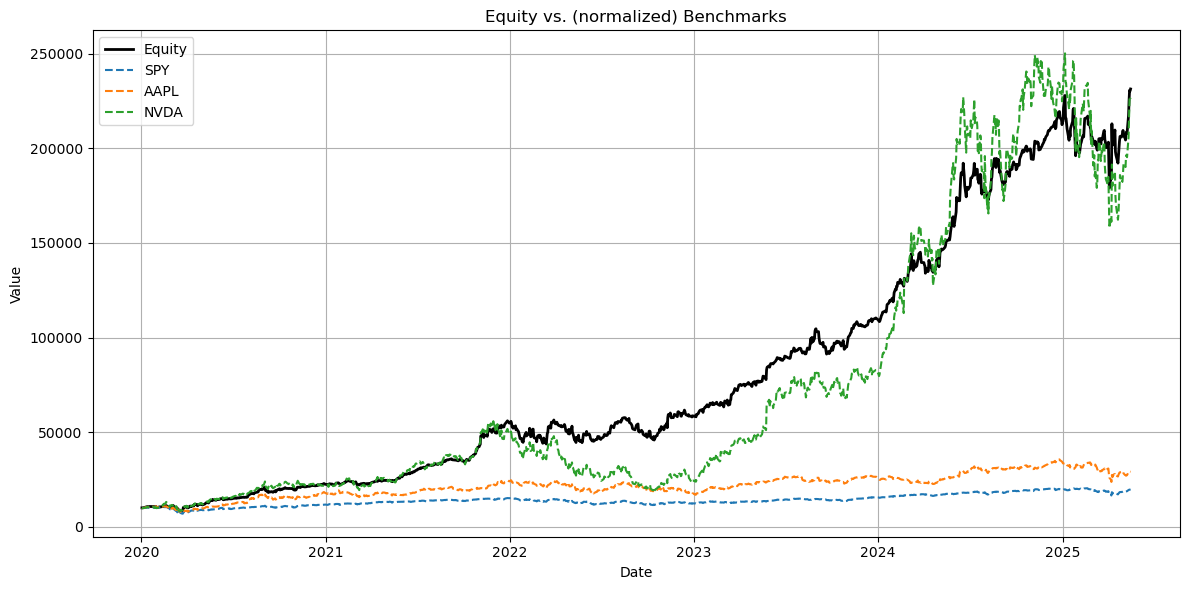

In [12]:
bt.equity_vs_benchmarks(benchmarks=tickers)

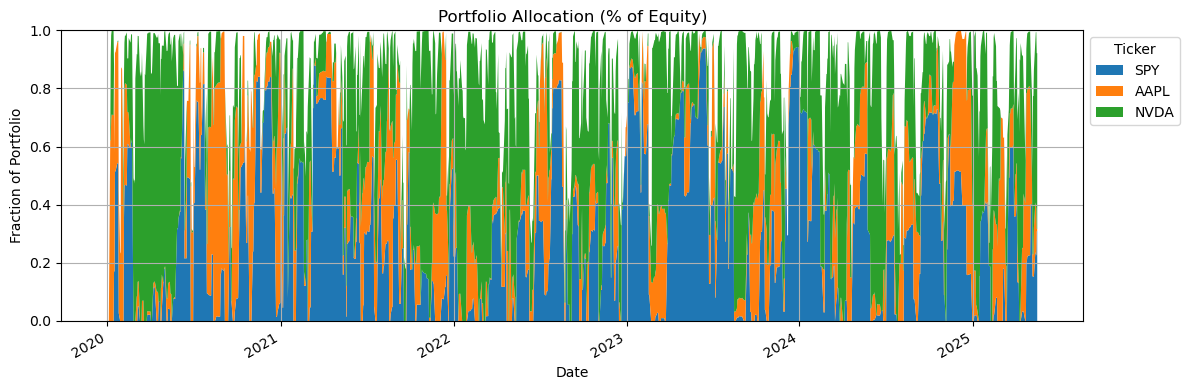

In [13]:
bt.holdings_over_time()

<h1> Sanity Check </h1>

In [14]:
bt.portfolio.order_history[:10]

[{'ticker': 'AAPL',
  'timestamp': '2020-01-06T00:00:00+00:00',
  'size': 87,
  'price': 71.1292012719,
  'commission': 0.0},
 {'ticker': 'NVDA',
  'timestamp': '2020-01-07T00:00:00+00:00',
  'size': 496,
  'price': 5.9296944419,
  'commission': 0.0},
 {'ticker': 'AAPL',
  'timestamp': '2020-01-08T00:00:00+00:00',
  'size': 10,
  'price': 71.9451085808,
  'commission': 0.0},
 {'ticker': 'AAPL',
  'timestamp': '2020-01-09T00:00:00+00:00',
  'size': 2,
  'price': 74.3855672377,
  'commission': 0.0},
 {'ticker': 'NVDA',
  'timestamp': '2020-01-14T00:00:00+00:00',
  'size': -496.0,
  'price': 6.2299132285,
  'commission': 0.0},
 {'ticker': 'SPY',
  'timestamp': '2020-01-14T00:00:00+00:00',
  'size': 6,
  'price': 302.5092972001,
  'commission': 0.0},
 {'ticker': 'AAPL',
  'timestamp': '2020-01-15T00:00:00+00:00',
  'size': -42,
  'price': 75.5016896989,
  'commission': 0.0},
 {'ticker': 'SPY',
  'timestamp': '2020-01-16T00:00:00+00:00',
  'size': 12,
  'price': 304.569320203,
  'commission

In [15]:
# start with initial cash
# go through order history, update cash according to buy/sell.
# make sure cash never goes negatie. i have allowd upto -100 because order recommendations
# are generated based on previous day's closing price. next day's opening price, when the
# order is executed, may be a bit higher, requiring slightly negative cash.
# update position as we go along, and check if it ever goes negative
cash = portfolio_registry.get('default').cash
pos = portfolio_registry.get('default').positions
print("starting cash: ", cash)
print("starting position: ", pos)
for order in bt.portfolio.order_history:
    cash -= data[order['ticker']]['adjOpen'].loc[order['timestamp']] * order['size']
    current = pos.get(order['ticker'], 0)
    pos[order['ticker']] = current + order['size']
    if cash < -100:
        print(data[order['ticker']]['adjOpen'].loc[order['timestamp']], " ", order['price'])
        print("negative cash")
    if pos[order['ticker']] < 0:
        print(order['ticker'], " ", order['timestamp'])
        print("negative position")

print("final cash: ", cash)
print("final position: ", pos)

starting cash:  10000
starting position:  {}
final cash:  17765.579555378397
final position:  {'AAPL': 8.0, 'NVDA': 1034.0, 'SPY': 121.0}


In [16]:
# compute equity by adding up final cash and final position value.
# for position we use the position calculated in the last step, 
# as opposed to the output of the backtesting.
# for ticker prices we use the final entry of the original dataframes, 
# as opposed to the output of the backtesting.
eq = cash + np.sum([pos[tk] * data[tk]['adjClose'].iloc[-1] for tk in bt.portfolio.positions])
print(eq)

231357.45955537842
